# 美国Washington.D.C共享单车提供的自行车数据线性回归分析

In [1]:
#load numerical packages

import numpy as np #矩阵操作
import pandas as pd #SQL数据处理

from sklearn.metrics import r2_score #评价回归预测模型的性能

import matplotlib.pyplot as plt #画图
import seaborn as sns

#图形出现在notebook里面而不是新窗口
%matplotlib inline  


# 2.数据探索

2.1 读取数据

In [2]:
data1 = pd.read_csv('day.csv')
#通过观察前5行，了解数据的的特征（x）的情况
data1.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


2.2数据基本信息

样本数目、特征维数。每个特征的类型、空值样本的数目、数据类型。

In [3]:
data1.shape

(731, 16)

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [5]:
#查看空值
data1.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

没有空值 然后进行数据准备

In [6]:
#将2011年数据提取作为训练集，2012年数据作为预测数据集
data = data1.loc[:364]
data.tail(6)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
359,360,2011-12-26,1,0,12,1,1,0,1,0.321739,0.315535,0.506957,0.239465,430,887,1317
360,361,2011-12-27,1,0,12,0,2,1,2,0.325000,0.327633,0.762500,0.188450,103,1059,1162
361,362,2011-12-28,1,0,12,0,3,1,1,0.299130,0.279974,0.503913,0.293961,255,2047,2302
362,363,2011-12-29,1,0,12,0,4,1,1,0.248333,0.263892,0.574167,0.119412,254,2169,2423
363,364,2011-12-30,1,0,12,0,5,1,1,0.311667,0.318812,0.636667,0.134337,491,2508,2999
364,365,2011-12-31,1,0,12,0,6,0,1,0.410000,0.414121,0.615833,0.220154,665,1820,2485


2.3数据准备

In [7]:
#从原始数据中分离输入特征x和标签y
y = data['cnt'].values
X = data.drop(['cnt','casual','registered','dteday'],axis = 1)


#用于后续显示权重系数对应的特征
columns = X.columns


In [8]:
#将数据分割成训练数据与测试数据
from sklearn.model_selection import train_test_split

#随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33,
                                                   test_size = 0.2)

X_train.shape

(292, 12)

发现各特征差异较大，需要进行数据标准化预处理
标准化的目的在于避免原始数据特征值差异过大，导致训练得到的参数
权重不归一，无法比较各特征的重要性

In [9]:
#数据标准化
from sklearn.preprocessing import StandardScaler

#分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

#分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#对y做标准化，为的是不同问题的w差异不太大，同时正则参数的范围也有限
y_train = ss_y.fit_transform(y_train.reshape(-1,1))
y_test = ss_y.fit_transform(y_test.reshape(-1,1))

E:\Anaconda2\envs\bunnies\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# 确定模型类型

3.1尝试缺省参数的线性回归

In [10]:
#线性回归
#使用默认配置初始化
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

#训练模型参数
lr.fit(X_train, y_train)

#预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)

#看看各种特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({'columns':list(columns),'coef':list((lr.coef_.T))})
fs.sort_values(['coef'],ascending = False)



,coef,columns
3,[0.777971753389],mnth
8,[0.744227636144],temp
1,[0.283648718854],season
5,[0.0346092682985],weekday
6,[0.0183037655029],workingday
2,[2.98372437868e-16],yr
10,[-0.012608287656],hum
4,[-0.074352930989],holiday
11,[-0.0982544869994],windspeed
9,[-0.117068895164],atemp


3.1.1模型评价

In [11]:
#使用r2_score评价模型在测试集和训练集上的性能，并输出评价结果
#测试集
print ('r2的线性回归在测试集评价分数是：',r2_score(y_test, y_test_pred_lr))
#训练集
print ('r2的线性回归评分在训练集分数是：',r2_score(y_train, y_train_pred_lr))

r2的线性回归在测试集评价分数是： 0.739251834558
r2的线性回归评分在训练集分数是： 0.760219200235


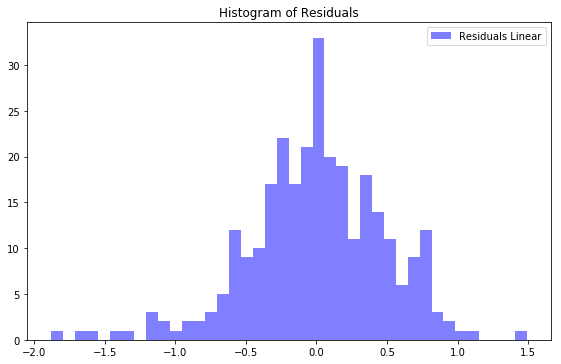

In [12]:
#在训练集上观察预测残差的分布，看是否呼和模型假设；噪声为0均值的高斯噪声
f,ax = plt.subplots(figsize = (8,5))
f.tight_layout()
ax.hist(y_train - y_train_pred_lr, bins = 40 , label='Residuals Linear', color = 'b',
        alpha = .5)
ax.set_title('Histogram of Residuals')
ax.legend(loc = 1)

残差有点向右倾斜，右态分布。

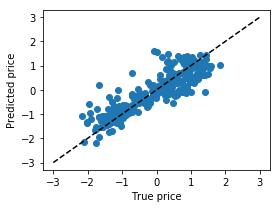

In [13]:
#还可以观察预测值与真值的散点图
plt.figure(figsize =(4, 3))
plt.scatter(y_train, y_train_pred_lr)
#数据已经标准化，3倍标准差
plt.plot([-3, 3],[-3, 3], '--k')  
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()



还比较合适预测效果。

3.2正则化的线性回归（L2正则-->岭回归）

In [14]:
#岭回归/L2正则

from sklearn.linear_model import RidgeCV

#设置超参数（正则参数）范围
alphas = [0.01, 0.1, 1, 10, 100]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas = alphas, store_cv_values= True)

#模型训练
ridge.fit(X_train, y_train)

#预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)

#评估，使用r2_score评价模型在测试集和训练集上的性能
print ('岭回归r2在测试集上的分数：',r2_score(y_test, y_test_pred_ridge))
print ('岭回归r2在训练集上的分数：',r2_score(y_train, y_train_pred_ridge))

岭回归r2在测试集上的分数： 0.743219161441
岭回归r2在训练集上的分数： 0.7588706882


# 可视化

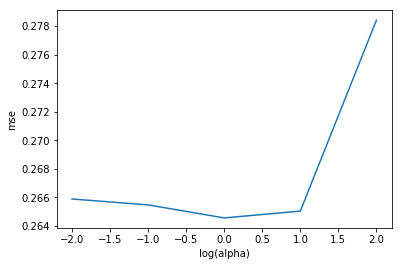

alpha is : 1.0


,coef_lr,coef_ridge,columns
3,[0.777971753389],[0.373080078187],mnth
8,[0.744227636144],[0.503967533561],temp
1,[0.283648718854],[0.2864224195],season
5,[0.0346092682985],[0.0350160783081],weekday
6,[0.0183037655029],[0.0187701103325],workingday
2,[2.98372437868e-16],[0.0],yr
10,[-0.012608287656],[-0.0184069850549],hum
4,[-0.074352930989],[-0.0750229961033],holiday
11,[-0.0982544869994],[-0.0951016850171],windspeed
9,[-0.117068895164],[0.122795650351],atemp


In [15]:
mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas),mse_mean.reshape(len(alphas),1))

#这是为了标出最佳参数的位置
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print('alpha is :',ridge.alpha_)

#看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({'columns':list(columns),'coef_lr':list((lr.coef_.T)),'coef_ridge':list((ridge.coef_.T))})
fs.sort_values(['coef_lr'],ascending = False)

# 3.3正则化的线性回归（L1正则-->Lasso）

In [16]:
#Lasso/L1正则
from sklearn.linear_model import LassoCV

#设置参超参数搜索范围
lasso = LassoCV()

#训练
lasso.fit(X_train, y_train)

#测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)

#评估，使用r2_score评价模型在测试集和训练集上的性能
print('测试集的lassoCV的r2分数：',r2_score(y_test, y_test_pred_lasso))
print('训练集的lassoCV的r2分数：',r2_score(y_train, y_train_pred_lasso))

测试集的lassoCV的r2分数： 0.740602139171
训练集的lassoCV的r2分数： 0.751889620509


E:\Anaconda2\envs\bunnies\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


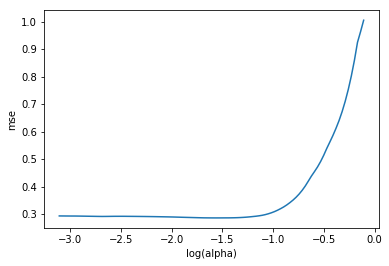

alpha is: 0.0273961650586


,coef_lasso,coef_lr,coef_ridge,columns
3,0.000000,[0.777971753389],[0.373080078187],mnth
8,0.596023,[0.744227636144],[0.503967533561],temp
1,0.266958,[0.283648718854],[0.2864224195],season
5,0.004808,[0.0346092682985],[0.0350160783081],weekday
6,0.000000,[0.0183037655029],[0.0187701103325],workingday
2,0.000000,[2.98372437868e-16],[0.0],yr
10,-0.000000,[-0.012608287656],[-0.0184069850549],hum
4,-0.060069,[-0.074352930989],[-0.0750229961033],holiday
11,-0.070833,[-0.0982544869994],[-0.0951016850171],windspeed
9,0.012376,[-0.117068895164],[0.122795650351],atemp


In [17]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses)

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print('alpha is:', lasso.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)


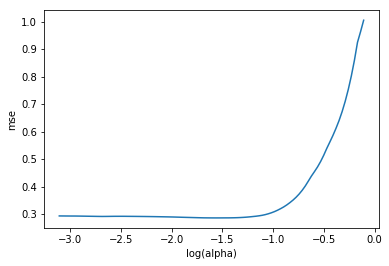

alpha is: 0.0273961650586


In [18]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print ('alpha is:', lasso.alpha_)